In [4]:
import os
from pathlib import Path

# 方法 1：相對於 notebook 位置
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent  # 從 model/aapl 往上兩層
os.chdir(project_root)

In [5]:
import torch
import torch.nn as nn 
import numpy as np
import pandas as pd
import numpy as np
import ta

In [6]:
df = pd.read_csv("data/AAPL.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'], window=14)
df['k'] = stoch.stoch()
df['d'] = stoch.stoch_signal()
df

,Close,High,Low,Open,Volume,rsi,k,d
Date,,,,,,,,
2014-01-06,16.871346,16.960365,16.550935,16.670353,412610800,NaN,NaN,NaN
2014-01-07,16.750681,16.934304,16.684924,16.883435,317209200,NaN,NaN,NaN
2014-01-08,16.856766,16.921901,16.708813,16.712533,258529600,NaN,NaN,NaN
2014-01-09,16.641502,16.962223,16.605212,16.960361,279148800,NaN,NaN,NaN
2014-01-10,16.530458,16.774256,16.473696,16.744168,304976000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-12-22,191.788773,193.581837,191.164662,193.353978,37149600,54.672823,36.229135,52.092899
2023-12-26,191.243927,192.076065,191.025984,191.798686,28919300,53.090083,19.878370,38.505327
2023-12-27,191.342941,191.689673,189.302216,190.689128,48087700,53.354360,24.149983,26.752496


In [7]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Volume','rsi','k','d']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 5 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

print(Y_train.shape)
train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
X_train.shape[2]
X_val.shape[0]
X_test.shape

(2514, 4)
torch.Size([1996, 5, 4])


torch.Size([208, 40, 4])

In [8]:
Y_val.shape

torch.Size([222, 5, 4])

In [9]:
Y_train.shape

torch.Size([1996, 5, 4])

In [10]:
Y_train.shape

torch.Size([1996, 5, 4])

In [11]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # 建立一個位置編碼矩陣
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶數位置
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇數位置
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x 的形狀為 (seq_length, batch_size, d_model)
        x = x + self.pe[:x.size(0)]
        return x

In [12]:
class TransformerTimeSeriesAutoregressive(nn.Module):
    def __init__(self, feature_size, num_layers=2, nhead=4, hidden_dim=128, lstm_hidden_dim=128, dropout=0.3):
        super(TransformerTimeSeriesAutoregressive, self).__init__()
        self.model_type = 'Autoregressive Transformer with LSTM Decoder and Teacher Forcing'

        self.input_linear = nn.Linear(feature_size, hidden_dim)
        self.pos_encoder = PositionalEncoding(d_model=hidden_dim)
        encoder_layers = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        # Linear projection for h_0 and c_0
        self.h0_projection = nn.Linear(hidden_dim, lstm_hidden_dim)
        self.c0_projection = nn.Linear(hidden_dim, lstm_hidden_dim)

        self.lstm_decoder = nn.LSTM(input_size=hidden_dim, hidden_size=lstm_hidden_dim, num_layers=1, batch_first=False)
        self.output_linear = nn.Linear(lstm_hidden_dim, feature_size)

        self.residual_projection = nn.Linear(feature_size, hidden_dim) if feature_size != hidden_dim else None
        self.hidden_dim = hidden_dim
        self.lstm_hidden_dim = lstm_hidden_dim

    def forward(self, src, target=None, teacher_forcing_ratio=0.5):
        batch_size, seq_length, feature_size = src.size()
        pred_length = target.size(1) if target is not None else 5

        if self.residual_projection:
            residual_src = self.residual_projection(src)
        else:
            residual_src = src
        
        residual_src = residual_src.permute(1, 0, 2)
        src = src.permute(1, 0, 2)
        src = self.input_linear(src)
        src = self.pos_encoder(src)

        transformer_output = self.transformer_encoder(src)
        transformer_output = transformer_output + residual_src

        # Use the last timestep's output to initialize h_0 and c_0
        last_step_output = transformer_output[-1]  # (batch_size, hidden_dim)
        h_0 = self.h0_projection(last_step_output).unsqueeze(0)  # (1, batch_size, lstm_hidden_dim)
        c_0 = self.c0_projection(last_step_output).unsqueeze(0)  # (1, batch_size, lstm_hidden_dim)

        # Start autoregressive decoding
        decoder_input = transformer_output[-1, :, :].unsqueeze(0)  # (1, batch_size, hidden_dim)
        outputs = []

        for t in range(pred_length):
            lstm_output, (h_0, c_0) = self.lstm_decoder(decoder_input, (h_0, c_0))
            lstm_output = lstm_output + decoder_input
            output = self.output_linear(lstm_output.squeeze(0))
            outputs.append(output.unsqueeze(1))

            if target is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input = self.input_linear(target[:, t, :]).unsqueeze(0)
            else:
                decoder_input = self.input_linear(output).unsqueeze(0)

        outputs = torch.cat(outputs, dim=1)
        return outputs


In [13]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 1e-4

feature_size = 4  # 輸入特徵數
num_layers = 2
nhead = 4
hidden_dim = 128

model = TransformerTimeSeriesAutoregressive(feature_size=feature_size, num_layers=num_layers, nhead=nhead, hidden_dim=hidden_dim).to(device)


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


c:\Users\N98141062\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [14]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_loss = 100
min_val_loss = float('inf')
best_model_path = "output/model/aapl/trans_lstm_5.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch= x_batch.to(device)
        # print(x_batch.shape)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.5).squeeze(-1)
        # print(outputs.shape)
        # print(y_batch.shape)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch, y_batch, teacher_forcing_ratio=0.0).squeeze(-1)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    if val_loss < min_val_loss and epoch>50:
        min_val_loss = val_loss
        torch.save(model, best_model_path)  
        print(f"Model saved with val_loss: {val_loss:.4f}")
    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/100], Train Loss: 0.0466, Val Loss: 0.1046
Epoch [2/100], Train Loss: 0.0619, Val Loss: 0.1016
Epoch [3/100], Train Loss: 0.0239, Val Loss: 0.0189
Epoch [4/100], Train Loss: 0.0100, Val Loss: 0.0052
Epoch [5/100], Train Loss: 0.0054, Val Loss: 0.0059
Epoch [6/100], Train Loss: 0.0045, Val Loss: 0.0041
Epoch [7/100], Train Loss: 0.0040, Val Loss: 0.0036
Epoch [8/100], Train Loss: 0.0034, Val Loss: 0.0022
Epoch [9/100], Train Loss: 0.0030, Val Loss: 0.0019
Epoch [10/100], Train Loss: 0.0027, Val Loss: 0.0013
Epoch [11/100], Train Loss: 0.0025, Val Loss: 0.0020
Epoch [12/100], Train Loss: 0.0023, Val Loss: 0.0011
Epoch [13/100], Train Loss: 0.0019, Val Loss: 0.0013
Epoch [14/100], Train Loss: 0.0017, Val Loss: 0.0010
Epoch [15/100], Train Loss: 0.0016, Val Loss: 0.0009
Epoch [16/100], Train Loss: 0.0014, Val Loss: 0.0011
Epoch [17/100], Train Loss: 0.0013, Val Loss: 0.0013
Epoch [18/100], Train Loss: 0.0012, Val Loss: 0.0015
Epoch [19/100], Train Loss: 0.0011, Val Loss: 0.0010
Ep

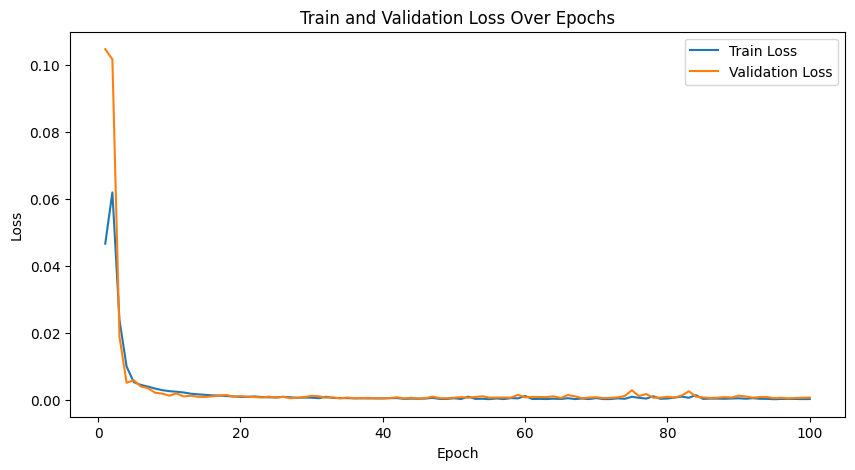

In [15]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

C:\Users\N98141062\AppData\Local\Temp\ipykernel_26536\1833441927.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('output/model/aapl/trans_lstm_5.pth')

MAE:  8.4022
RMSE: 8.7957
MAPE: 21.5059%
R²:   0.9544


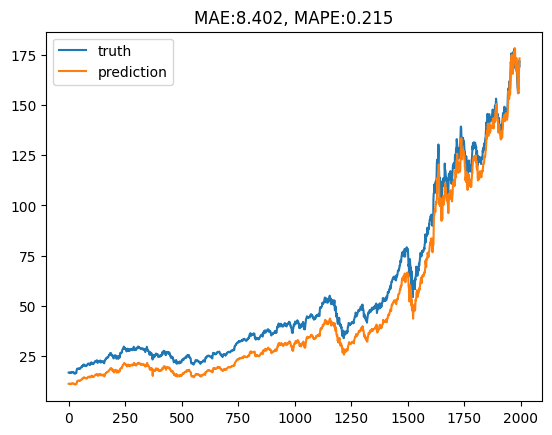

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
close_price_true = []
close_price_pred = []
model = torch.load('output/model/aapl/trans_lstm_5.pth')
model.to(device)

dim = 0
for i in range(len(train_set)):
    x,y = train_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0).squeeze(-1)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['truth', 'prediction'])
# 輸出所有指標
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

In [17]:
newdf = pd.DataFrame({'close':close_price_true, 'rsi':df['rsi'][:1996],'predicted_close':close_price_pred})
newdf

,close,rsi,predicted_close
Date,,,
2014-01-06,16.611309,NaN,11.040370
2014-01-07,16.561073,NaN,11.060006
2014-01-08,16.551403,NaN,11.069005
2014-01-09,16.566381,NaN,11.032484
2014-01-10,16.727699,NaN,11.020385
...,...,...,...
2021-12-01,166.830295,69.945890,158.083572
2021-12-02,171.188875,67.164756,163.943785
2021-12-03,171.022365,62.109006,169.553862


In [18]:
import pandas as pd
import numpy as np
import random
import ta


# 含資金管理邏輯的策略：每次 all-in
def evaluate_strategy_dynamic(df, rsi_buy, rsi_sell, initial_cash=1000000):
    df = df.copy()
    in_position = False
    entry_price = 0
    shares = 0
    cash = initial_cash

    for i in range(len(df)):
        if not in_position:
            if (
                df.loc[i, 'rsi'] < rsi_buy
                # df.loc[i, 'predicted_close'] > df.loc[i, 'close'] * price_buy
            ):
                entry_price = df.loc[i, 'close']
                shares = cash // entry_price  # 整股 all-in
                cash -= shares * entry_price
                in_position = True
                # print('買入價格:',entry_price)
        else:
            if (
                df.loc[i, 'rsi'] > rsi_sell
                # df.loc[i, 'predicted_close'] < df.loc[i, 'close']*price_sell
            ):
                exit_price = df.loc[i, 'close']
                cash += shares * exit_price
                shares = 0
                in_position = False
                # print('賣出價格:',exit_price)

    # 若還持股，最後一日平倉
    if in_position:
        cash += shares * df.loc[len(df) - 1, 'close']

    return cash  # 回傳總收入

# GA 演化主體
def genetic_optimize_dynamic(df, pop_size=20, generations=15, mutation_rate=0.01):
    def random_chromosome():
        return [
            random.uniform(0, 40),    # rsi_buy
            # random.uniform(1.00, 1.05),# price_f
            random.uniform(60, 100)     # rsi_sell
        ]

    def mutate(chrom):
        if random.random() < mutation_rate:
            chrom[0] = random.uniform(0, 40)
        # if random.random() < mutation_rate:
            # chrom[0] = random.uniform(1.00, 1.05)
        if random.random() < mutation_rate:
            chrom[1] = random.uniform(60, 100)
        return chrom

    def crossover(p1, p2):
        # point = random.randint(1, 2)
        point = 1
        return p1[:point] + p2[point:]

    population = [random_chromosome() for _ in range(pop_size)]

    for _ in range(generations):
        scored = [(evaluate_strategy_dynamic(df, chrom[0], chrom[1]), chrom) for chrom in population]
        scored.sort(key=lambda x: -x[0])
        survivors = [chrom for _, chrom in scored[:pop_size // 2]]
        new_pop = survivors[:]
        while len(new_pop) < pop_size:
            p1, p2 = random.sample(survivors, 2)
            child = mutate(crossover(p1, p2))
            new_pop.append(child)
        population = new_pop

    final_scores = [(evaluate_strategy_dynamic(df, chrom[0], chrom[1]), chrom) for chrom in population]
    final_scores.sort(key=lambda x: -x[0])
    return final_scores[0]  # 回傳最佳淨利與參數

In [19]:
newdf = newdf.dropna().reset_index(drop=True)
best_profit, best_params = genetic_optimize_dynamic(newdf)
print("最佳淨利：", best_profit)
print("最佳參數：", best_params)

最佳淨利： 13899561.171472989
最佳參數： [37.48137991078433, 83.64270882329986]


In [20]:
import pandas as pd
import numpy as np
import random
import ta


# 含資金管理邏輯的策略：每次 all-in
def evaluate_strategy_dynamic(df, rsi_buy, rsi_sell, initial_cash=1000000):
    df = df.copy()
    in_position = False
    entry_price = 0
    shares = 0
    cash = initial_cash

    for i in range(len(df)):
        if not in_position:
            if (
                df.loc[i, 'rsi'] < rsi_buy
                # and df.loc[i, 'predicted_close'] > df.loc[i, 'close'] * price_f
            ):
                entry_price = df.loc[i, 'close']
                shares = cash // entry_price  # 整股 all-in
                cash -= shares * entry_price
                in_position = True
                # print('買入價格:',entry_price)
        else:
            if (
                df.loc[i, 'rsi'] > rsi_sell
                # df.loc[i, 'predicted_close'] < df.loc[i, 'close']
            ):
                exit_price = df.loc[i, 'close']
                cash += shares * exit_price
                shares = 0
                in_position = False
                # print('賣出價格:',exit_price)

    # 若還持股，最後一日平倉
    if in_position:
        cash += shares * df.loc[len(df) - 1, 'close']

    return cash  # 回傳總收入

# GA 演化主體
def genetic_optimize_dynamic(df, pop_size=20, generations=15, mutation_rate=0.01):
    def random_chromosome():
        return [
            random.uniform(20, 40),    # rsi_buy
            # random.uniform(1.00, 1.05),# price_f
            random.uniform(50, 80)     # rsi_sell
        ]

    def mutate(chrom):
        if random.random() < mutation_rate:
            chrom[0] = random.uniform(20, 40)
        # if random.random() < mutation_rate:
            # chrom[0] = random.uniform(1.00, 1.05)
        if random.random() < mutation_rate:
            chrom[1] = random.uniform(50, 80)
        return chrom

    def crossover(p1, p2):
        # point = random.randint(1, 2)
        point = 1
        return p1[:point] + p2[point:]

    population = [random_chromosome() for _ in range(pop_size)]

    for _ in range(generations):
        scored = [(evaluate_strategy_dynamic(df, chrom[0], chrom[1]), chrom) for chrom in population]
        scored.sort(key=lambda x: -x[0])
        survivors = [chrom for _, chrom in scored[:pop_size // 2]]
        new_pop = survivors[:]
        while len(new_pop) < pop_size:
            p1, p2 = random.sample(survivors, 2)
            child = mutate(crossover(p1, p2))
            new_pop.append(child)
        population = new_pop

    final_scores = [(evaluate_strategy_dynamic(df, chrom[0], chrom[1]), chrom) for chrom in population]
    final_scores.sort(key=lambda x: -x[0])
    return final_scores[0]  # 回傳最佳淨利與參數

C:\Users\N98141062\AppData\Local\Temp\ipykernel_26536\656742245.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('output/model/aapl/trans_lstm_5.pth')


MAE:  2.4857
RMSE: 3.2711
MAPE: 1.4405%
R²:   0.9298


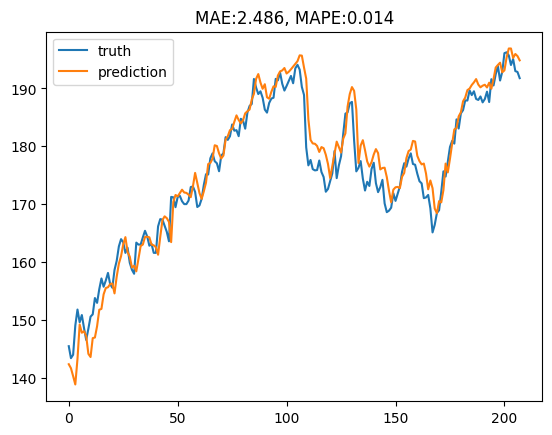

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
close_price_true = []
close_price_pred = []
model = torch.load('output/model/aapl/trans_lstm_5.pth')
model.to(device)

dim = 0
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0).squeeze(-1)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[0,dim])
    close_price_true.append(scaler.inverse_transform(y)[0,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[0,dim])

mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}'.format(mae, mape))
plt.legend(['truth', 'prediction'])
# 輸出所有指標
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

In [22]:
btdf = pd.DataFrame({'close':close_price_true, 'rsi':df['rsi'][-213:-5],'predicted_close':close_price_pred})

In [23]:
btdf =btdf.dropna().reset_index(drop=True)

In [24]:
btdf

,close,rsi,predicted_close
0,145.440919,51.156447,142.323989
1,143.368974,50.113127,141.635908
2,143.960941,45.956782,140.265371
3,149.012557,47.301589,138.819935
4,151.775179,57.109919,143.239063
...,...,...,...
203,194.057324,67.991817,196.916738
204,195.097503,62.680133,195.274388
205,193.007264,64.544443,195.967963
206,192.858661,58.247505,195.600684


買入價格: 177.64362982871128
賣出價格: 187.91533254155533
cash: 1057819.4145705993
額外要扣掉: 4519.121787619003
扣掉後的: 1053300.2927829803
-------------------------------------
最終價格: 1053300.2927829803


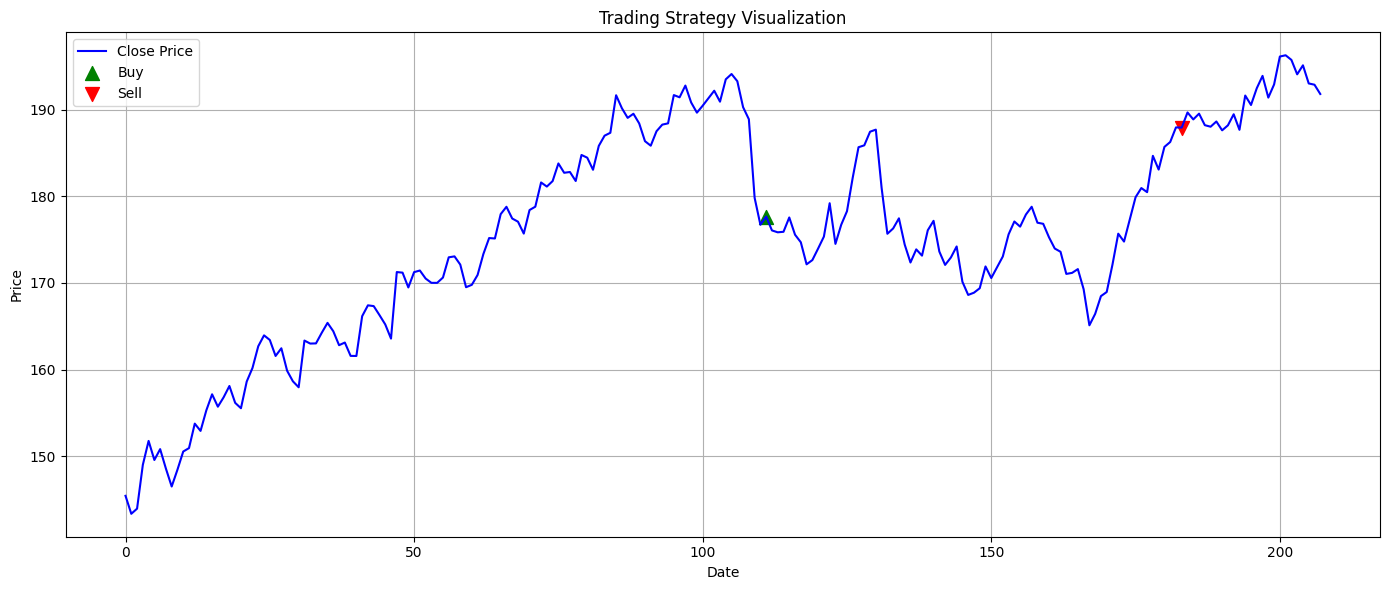

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1.5‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'rsi'] < 30:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'rsi'] > 70:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    need_pay += cash * (fee_rate + tax_rate)
    cash -= need_pay
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


買入價格: 176.70500416773584
賣出價格: 191.78876734499968
最終價格: 1080759.3406988622


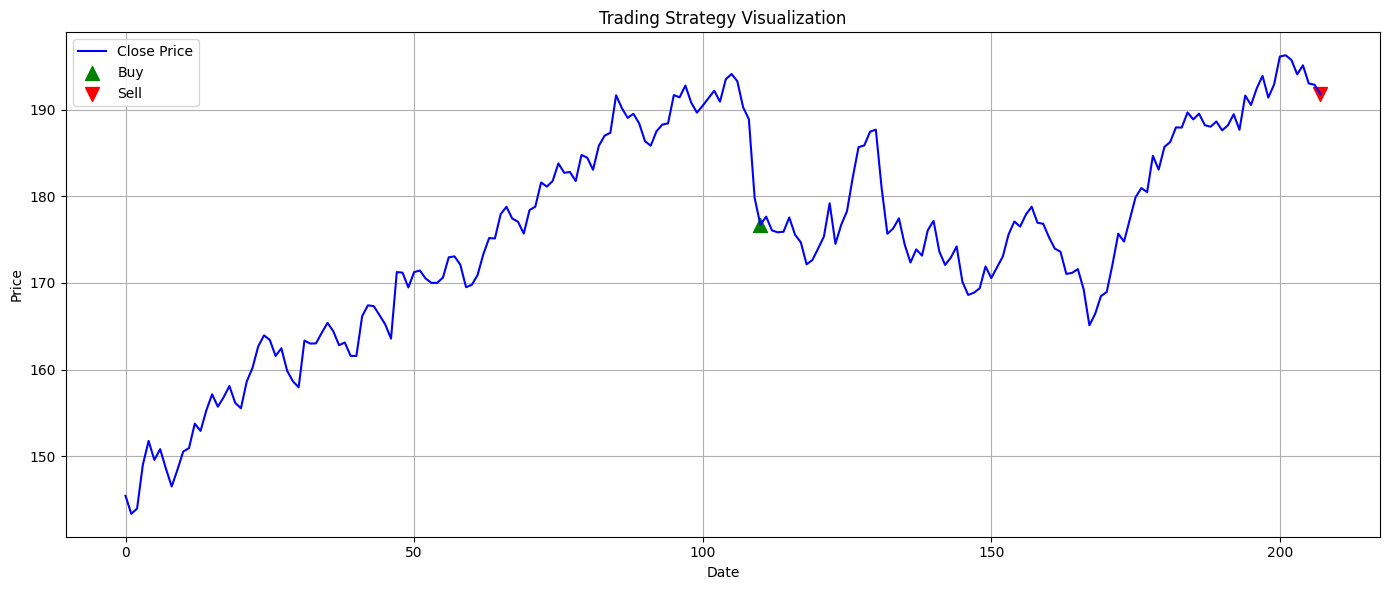

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1.5‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'rsi'] < 39.079:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'rsi'] > 76.032 :
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    need_pay += cash * (fee_rate + tax_rate)
    cash -= need_pay
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


買入價格: 155.54409745350873
賣出價格: 158.6224569260569
cash: 1019790.7730490123
額外要扣掉: 4407.888011168361
扣掉後的: 1015382.885037844
-------------------------------------
買入價格: 161.57254334021994
賣出價格: 159.86561528217052
cash: 1004656.5491210615
額外要扣掉: 4385.541017358033
扣掉後的: 1000271.0081037034
-------------------------------------
買入價格: 157.96140787151816
賣出價格: 163.00318764980395
cash: 1032195.5576598089
額外要扣掉: 4444.558192702719
扣掉後的: 1027750.9994671062
-------------------------------------
買入價格: 165.39084852500505
賣出價格: 164.42388772682543
cash: 1021742.3050672179
額外要扣掉: 4453.141416562239
扣掉後的: 1017289.1636506557
-------------------------------------
買入價格: 163.12153802325943
賣出價格: 161.5823798346182
cash: 1007690.9731862888
額外要扣掉: 4397.133154772079
扣掉後的: 1003293.8400315167
-------------------------------------
買入價格: 161.57254334021994
賣出價格: 166.16041145860103
cash: 1031779.913178545
額外要扣掉: 4447.649968092155
扣掉後的: 1027332.2632104529
-------------------------------------
買入價格: 166.2886521955369
賣出

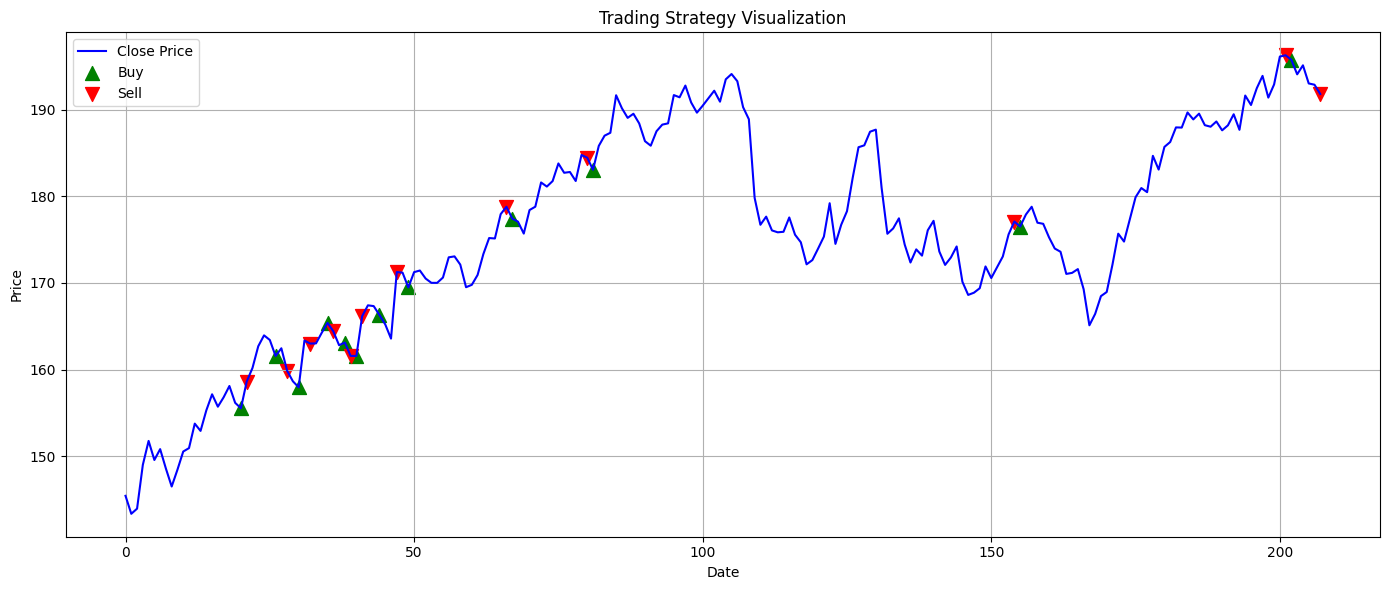

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


買入價格: 155.54409745350873
賣出價格: 191.78876734499968
最終價格: 1233016.9827323954


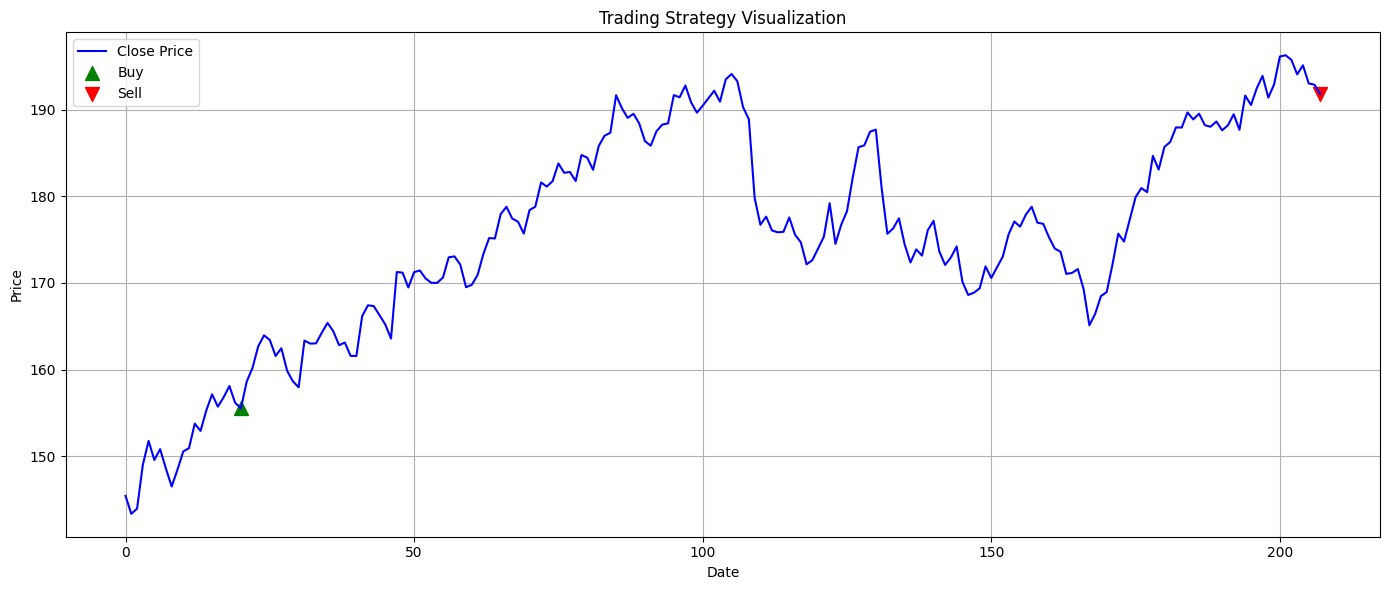

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# 初始化參數
initial_cash = 1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash

# 儲存交易點資訊
buy_dates = []
buy_prices = []
sell_dates = []
sell_prices = []

# 手續費和稅率
fee_rate = 0.001425  # 手續費率 (1.425‰)
tax_rate = 0.0015     # 證券交易稅率 (1.5‰)
need_pay = 0 #需要付的手續費+稅金

# 模擬交易
for i in range(1, len(btdf)):
    if not in_position:
        need_pay = 0
        if btdf.loc[i, 'predicted_close'] > btdf.loc[i - 1, 'close']:
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price
            need_pay += cash * fee_rate
            cash -= shares * entry_price
            in_position = True

            buy_dates.append(btdf.index[i])
            buy_prices.append(entry_price)

            print('買入價格:', entry_price)

    else:
        if btdf.loc[i, 'rsi'] > 76.032 and btdf.loc[i, 'predicted_close'] < btdf.loc[i - 1, 'close']:
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            need_pay += cash * (fee_rate + tax_rate)
            shares = 0
            in_position = False

            sell_dates.append(btdf.index[i])
            sell_prices.append(exit_price)

            print('賣出價格:', exit_price)
            print('cash:', cash)
            print('額外要扣掉:', need_pay)
            cash -= need_pay
            print('扣掉後的:', cash)
            print('-------------------------------------')

# 最後一天強制平倉
if in_position:
    final_price = btdf.loc[len(btdf) - 1, 'close']
    cash += shares * final_price
    sell_dates.append(btdf.index[-1])
    sell_prices.append(final_price)
    print('賣出價格:', final_price)

# 顯示最終資金
print('最終價格:', cash)

# 繪圖
plt.figure(figsize=(14, 6))
plt.plot(btdf.index, btdf['close'], label='Close Price', color='blue')

# 標記買進與賣出點
plt.scatter(buy_dates, buy_prices, color='green', label='Buy', marker='^', s=100)
plt.scatter(sell_dates, sell_prices, color='red', label='Sell', marker='v', s=100)

plt.title('Trading Strategy Visualization')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
initial_cash=1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash
for i in range(1,len(btdf)):
    if not in_position:
        if (
            btdf.loc[i, 'predicted_close'] > btdf.loc[i-1, 'close']
        ):
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price  # 整股 all-in
            cash -= shares * entry_price
            print('買入價格:',entry_price)
            in_position = True
            # print('買入價格:',entry_price)
    else:
        if (
            btdf.loc[i, 'rsi'] > 72.925 and
            btdf.loc[i, 'predicted_close'] < btdf.loc[i-1, 'close']
        ):
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            shares = 0
            print('賣出價格:',exit_price)
            in_position = False
            print('cash:',cash)
# 若還持股，最後一日平倉
if in_position:
    cash += shares * btdf.loc[len(btdf) - 1, 'close']
    print('賣出價格:',btdf.loc[len(btdf) - 1, 'close'])
print('最終價格:',cash)

買入價格: 155.54409745350873
賣出價格: 191.78876734499968
最終價格: 1233016.9827323954


In [30]:
initial_cash=1000000
in_position = False
entry_price = 0
shares = 0
cash = initial_cash
for i in range(1,len(btdf)):
    if not in_position:
        if (
            btdf.loc[i, 'predicted_close'] > btdf.loc[i-1, 'close']
        ):
            entry_price = btdf.loc[i, 'close']
            shares = cash // entry_price  # 整股 all-in
            cash -= shares * entry_price
            print('買入價格:',entry_price)
            in_position = True
            # print('買入價格:',entry_price)
    else:
        if (
            # btdf.loc[i, 'rsi'] > 52.048 or
            btdf.loc[i, 'predicted_close'] < btdf.loc[i-1, 'close']
        ):
            exit_price = btdf.loc[i, 'close']
            cash += shares * exit_price
            shares = 0
            print('賣出價格:',exit_price)
            in_position = False
            print('cash:',cash)
print(cash)

買入價格: 155.54409745350873
賣出價格: 158.6224569260569
cash: 1019790.7730490123
買入價格: 161.57254334021994
賣出價格: 159.86561528217052
cash: 1009018.3500746625
買入價格: 157.96140787151816
賣出價格: 163.00318764980395
cash: 1041220.1975185738
買入價格: 165.39084852500505
賣出價格: 164.42388772682543
cash: 1035133.1792940331
買入價格: 163.12153802325943
賣出價格: 161.5823798346182
cash: 1025367.2205871044
買入價格: 161.57254334021994
賣出價格: 166.16041145860103
cash: 1054481.8316663508
買入價格: 166.2886521955369
賣出價格: 171.25145989940953
cash: 1085950.9953166072
買入價格: 169.47548245187662
賣出價格: 178.77980418770036
cash: 1145563.7846780298
買入價格: 177.42625730847115
賣出價格: 184.4410999581971
cash: 1190851.6088246605
買入價格: 183.04803472031202
賣出價格: 177.08214161177855
cash: 1152043.4741536505
買入價格: 176.48855819570846
賣出價格: 196.2565612792969
cash: 1281069.2302802322
買入價格: 195.72163051985783
71.15852776262909


In [31]:
import json

close_price_true = [item.tolist() for item in close_price_true]

In [32]:
with open('../test_price1.json', 'w') as f:
    json.dump(close_price_true, f)

In [33]:
close_price_true = []
close_price_pred = []

dim = 0
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device), y.to(device), teacher_forcing_ratio=0)
    # print(pred)
    # print(scaler.inverse_transform(torch.squeeze(pred.detach().cpu())))
    y=torch.squeeze(y)
    # print(scaler.inverse_transform(y)[:,dim])
    close_price_true.append(scaler.inverse_transform(y)[:,dim])
    close_price_pred.append(scaler.inverse_transform(torch.squeeze(pred.detach().cpu()))[:,dim])

print(np.array(close_price_true).shape)
print(np.array(close_price_pred).shape)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
# 新增：RMSE
rmse = np.sqrt(np.mean((np.array(close_price_true) - np.array(close_price_pred)) ** 2))
# 新增：R²
r2 = r2_score(close_price_true, close_price_pred)
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.4%}")
print(f"R²:   {r2:.4f}")

(208, 5)
(208, 5)
MAE:  3.1793
RMSE: 4.2274
MAPE: 1.8340%
R²:   0.8758


In [34]:
import json

close_price_true = [item.tolist() for item in close_price_true]


In [35]:
with open('../test_price.json', 'w') as f:
    json.dump(close_price_true, f)

In [ ]:
import csv

with open('output/aapl_output.csv', mode='r', newline='') as file:
    reader = csv.reader(file)
    rows = list(reader)

for i in range(len(close_price_pred)):
    rows[i].append(close_price_pred[i][0].item())

# 寫回檔案
with open('output/aapl_output.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(rows)